In [143]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModel
import torch
from torch import Tensor
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt

# Оценка энкодеров по метрике Accuracy@5

In [2]:
dataset = load_dataset('medical_questions_pairs')
data = dataset['train'].to_pandas()

In [50]:
print(f"Всего вопросов в question_1: {len(data)}")
print(f"Кол-во уникальных вопросов в question_1: {data['question_1'].nunique()}")
# У каждого вопроса в question_1 есть ровно два разных лэйбла
print(f"Список вариантов, сколько лэйблов может быть у question_1: {data.groupby('question_1').agg(count = ('question_1', 'count'))['count'].unique()}")

Всего вопросов в question_1: 3048
Кол-во уникальных вопросов в question_1: 1524
Список вариантов, сколько лэйблов может быть у question_1: [2]


In [44]:
print(f"Кол-во уникальных вопросов в question_2: {data['question_2'].nunique()}")
# У 4 вопросов из question_2 есть дубли (у одного вопроса два дубля), при этом у всех дэйблы 0, поэтому в оценке точности эти вопросы учитывать не будем
print("Дублирующиеся записи")
data[~data.index.isin(data[['question_2', 'label']].drop_duplicates().index)]


Кол-во уникальных вопросов в question_2: 3043
Дублирующиеся записи


,dr_id,question_1,question_2,label
72,1,I'm taking anxiety and depression medicine to ...,Can CBT be used to treat anxiety?,0
107,1,What is the cleanest/safest SSRI for general s...,Why do I have anxiety when I go in an elevator?,0
313,2,I have been taking my birthcontrol Amethia for...,I missed my pills for 2 days in a row... Can I...,0
333,2,I messed up my birth control and started a new...,I missed my pills for 2 days in a row... Can I...,0
374,2,I've had a cold for 1week. I just stopped anti...,How is Strep throat diagnosed? Do I need to se...,0


In [49]:
# Проверка, есть ли вопросы, встречающиеся в обоих столбцах.
set(data['question_1']) & set(data['question_2'])

set()

In [188]:
# Сделаем так, чтобы в одном столбце были все предложения
corpus = pd.concat([data[['question_1', 'question_2', 'label']], data.rename(
    columns={'question_1':'question_2', 'question_2':'question_1'})[['question_2', 'question_1', 'label']]]).drop_duplicates().reset_index(drop=True)
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6096 entries, 0 to 6095
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   question_1  6096 non-null   object
 1   question_2  6096 non-null   object
 2   label       6096 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 143.0+ KB


In [157]:
# Диагональная матрица со значениями лейблов
labels_diag_matrix = torch.diag(torch.tensor(corpus['label']))
# Кол-во пар, помеченных 1
cnt_ones = corpus['label'].sum()
# Индексы, строки которых помечены label = 1
# В оценке точности нужно использовать только те вопросы, у которых есть лэйбл 1
indexes_ones = list(corpus.query("label == 1").index)

# Словарь со значениями метрики для разных моделей
metrics = {}

In [158]:
# Функция, вычисляющая Accuracy@5
def top_n_accuracy(cosine_scores_matrix: Tensor, labels_diag_matrix:Tensor, cnt_ones:int, indexes_ones:list, n=5) -> float:
    # Найти индексы топ-5 значений в каждой строке
    _, top_indices = torch.topk(cosine_scores_matrix, k=n)
    cnt = 0
    for i in indexes_ones:
        if labels_diag_matrix[i][top_indices[i]].any():
            cnt += 1
    result = cnt / cnt_ones if cnt_ones > 0 else 0
    return result

In [159]:
# Функция, считающая косинусную схожесть и возвращающая результат в формате Тензора
def cos_sim(vec_1, vec_2) -> Tensor:
    # По умолчанию util.cos_sim возвращает тензор, но не срабатывает c разреженными sparse матрицами (scipy.sparse._csr.csr_matrix), которые получаются в tf-idf и bag-of-words
    # cosine_scores = util.cos_sim(embeddings_1, embeddings_2)

    # Воспользуемся sklearn
    cosine_scores = torch.tensor(cosine_similarity(vec_1, vec_2))
    # При сравнении одинаковых вопросов схожесть будет равна 1. Чтобы не учитывать такие записи, присвоим им схожесть 0
    cosine_scores[np.round(cosine_scores,4) == 1.0000] = 0
    return cosine_scores

# SentenceTransformer("all-MiniLM-L6-v2")

In [171]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings_1 = model.encode(corpus['question_1'], show_progress_bar=True)
embeddings_2 = model.encode(corpus['question_2'], show_progress_bar=True)

cosine_scores = cos_sim(embeddings_1, embeddings_2)
metrics['all-MiniLM-L6-v2'] = top_n_accuracy(cosine_scores, labels_diag_matrix, cnt_ones, indexes_ones)

Batches:   0%|          | 0/191 [00:00<?, ?it/s]

Batches:   0%|          | 0/191 [00:00<?, ?it/s]

In [172]:
metrics

{'all-MiniLM-L6-v2': 0.9560367454068242}

### То же самое проделаем с Pytorch


In [174]:
# Получим такой же результат, но фрэймворк SentenceTransformer удобнее и быстрее, не нужно отдельно прописывать разделение на батчи
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# Tokenize sentences
encoded_input_1 = tokenizer(
    list(corpus['question_1']), padding=True, truncation=True, max_length=128, return_tensors="pt"
)
encoded_input_2 = tokenizer(
    list(corpus['question_2']), padding=True, truncation=True, max_length=128, return_tensors="pt"
)

with torch.no_grad():
    model_output_1 = model(**encoded_input_1)

sentence_embeddings_1 = mean_pooling(model_output_1, encoded_input_1["attention_mask"])

with torch.no_grad():
    model_output_2 = model(**encoded_input_2)

sentence_embeddings_2 = mean_pooling(model_output_2, encoded_input_2["attention_mask"])

cosine_scores = cos_sim(sentence_embeddings_1, sentence_embeddings_2)
pytorch_MiniLM = top_n_accuracy(cosine_scores, labels_diag_matrix, cnt_ones, indexes_ones)
pytorch_MiniLM

0.9560367454068242

# SentenceTransformer("paraphrase-MiniLM-L6-v2")

In [175]:
model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
embeddings_1 = model.encode(corpus['question_1'], show_progress_bar=True)
embeddings_2 = model.encode(corpus['question_2'], show_progress_bar=True)

cosine_scores = cos_sim(embeddings_1, embeddings_2)
metrics['paraphrase-MiniLM-L6-v2'] = top_n_accuracy(cosine_scores, labels_diag_matrix, cnt_ones, indexes_ones)

Batches:   0%|          | 0/191 [00:00<?, ?it/s]

Batches:   0%|          | 0/191 [00:00<?, ?it/s]

In [177]:
metrics

{'all-MiniLM-L6-v2': 0.9560367454068242,
 'paraphrase-MiniLM-L6-v2': 0.9137139107611548}

# SentenceTransformer("all-mpnet-base-v2")

In [178]:
model = SentenceTransformer("all-mpnet-base-v2")
embeddings_1 = model.encode(corpus['question_1'], show_progress_bar=True)
embeddings_2 = model.encode(corpus['question_2'], show_progress_bar=True)

cosine_scores = cos_sim(embeddings_1, embeddings_2)
metrics['all-mpnet-base-v2'] = top_n_accuracy(cosine_scores, labels_diag_matrix, cnt_ones, indexes_ones)

Batches:   0%|          | 0/191 [00:00<?, ?it/s]

Batches:   0%|          | 0/191 [00:00<?, ?it/s]

In [179]:
# Резульаты близкие с первому (лучшему варианту), но процесс длится заметно дольше
metrics

{'all-MiniLM-L6-v2': 0.9560367454068242,
 'paraphrase-MiniLM-L6-v2': 0.9137139107611548,
 'all-mpnet-base-v2': 0.9550524934383202}

# SentenceTransformer("all-MiniLM-L12-v2")

In [180]:
model = SentenceTransformer("all-MiniLM-L12-v2")
embeddings_1 = model.encode(corpus['question_1'], show_progress_bar=True)
embeddings_2 = model.encode(corpus['question_2'], show_progress_bar=True)

cosine_scores = cos_sim(embeddings_1, embeddings_2)
metrics['all-MiniLM-L12-v2'] = top_n_accuracy(cosine_scores, labels_diag_matrix, cnt_ones, indexes_ones)

Batches:   0%|          | 0/191 [00:00<?, ?it/s]

Batches:   0%|          | 0/191 [00:00<?, ?it/s]

In [181]:
metrics

{'all-MiniLM-L6-v2': 0.9560367454068242,
 'paraphrase-MiniLM-L6-v2': 0.9137139107611548,
 'all-mpnet-base-v2': 0.9550524934383202,
 'all-MiniLM-L12-v2': 0.9507874015748031}

# TfidfVectorizer

In [182]:
# Посчитаем с использованием стоп-слов
vectorizer = TfidfVectorizer(stop_words='english')
vector_1 = vectorizer.fit_transform(corpus['question_1'])
vector_2 = vectorizer.transform(corpus['question_2'])

cosine_scores = cos_sim(vector_1, vector_2)
metrics['TfidfVectorizer_stopwords'] = top_n_accuracy(cosine_scores, labels_diag_matrix, cnt_ones, indexes_ones)

# Посчитаем без использования стоп-слов
vectorizer = TfidfVectorizer()
vector_1 = vectorizer.fit_transform(corpus['question_1'])
vector_2 = vectorizer.transform(corpus['question_2'])

cosine_scores = cos_sim(vector_1, vector_2)
metrics['TfidfVectorizer'] = top_n_accuracy(cosine_scores, labels_diag_matrix, cnt_ones, indexes_ones)

In [183]:
metrics

{'all-MiniLM-L6-v2': 0.9560367454068242,
 'paraphrase-MiniLM-L6-v2': 0.9137139107611548,
 'all-mpnet-base-v2': 0.9550524934383202,
 'all-MiniLM-L12-v2': 0.9507874015748031,
 'TfidfVectorizer_stopwords': 0.8346456692913385,
 'TfidfVectorizer': 0.8441601049868767}

# CountVectorizer()

In [185]:
# Посчитаем с использованием стоп-слов
vectorizer = CountVectorizer(stop_words='english')
vector_1 = vectorizer.fit_transform(corpus['question_1'])
vector_2 = vectorizer.transform(corpus['question_2'])

cosine_scores = cos_sim(vector_1, vector_2)
metrics['CountVectorizer_stopwords'] = top_n_accuracy(cosine_scores, labels_diag_matrix, cnt_ones, indexes_ones)

# Посчитаем без использования стоп-слов
vectorizer = CountVectorizer()
vector_1 = vectorizer.fit_transform(corpus['question_1'])
vector_2 = vectorizer.transform(corpus['question_2'])

cosine_scores = cos_sim(vector_1, vector_2)
metrics['CountVectorizer'] = top_n_accuracy(cosine_scores, labels_diag_matrix, cnt_ones, indexes_ones)

In [186]:
metrics

{'all-MiniLM-L6-v2': 0.9560367454068242,
 'paraphrase-MiniLM-L6-v2': 0.9137139107611548,
 'all-mpnet-base-v2': 0.9550524934383202,
 'all-MiniLM-L12-v2': 0.9507874015748031,
 'TfidfVectorizer_stopwords': 0.8346456692913385,
 'TfidfVectorizer': 0.8441601049868767,
 'CountVectorizer_stopwords': 0.7811679790026247,
 'CountVectorizer': 0.5485564304461942}

# Итоги

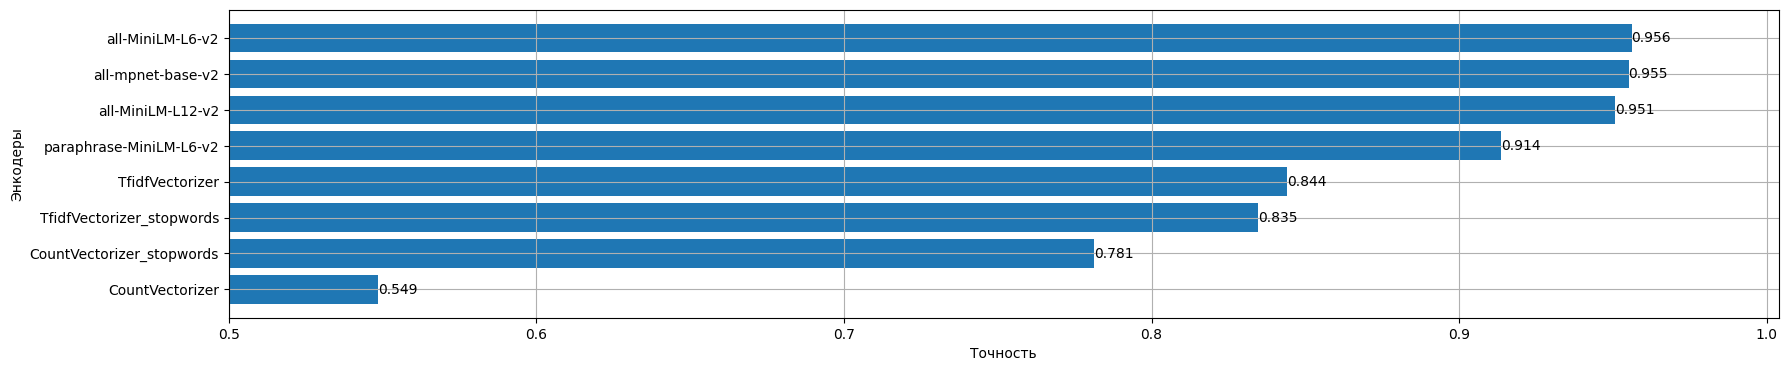

In [187]:
metrics_sorted = dict(sorted(metrics.items(), key=lambda item: item[1]))
plt.figure(figsize=(20, 4))
plt.barh(list(metrics_sorted.keys()), list(metrics_sorted.values()))
plt.xlabel('Точность')
plt.ylabel('Энкодеры')
for i, v in enumerate(metrics_sorted.values()):
    plt.text(v, i, str(round(v,3)), ha='left', va='center')
plt.xlim(0.5)
plt.grid()
plt.show()